# Shared response model
This notebook provides interactive examples of functional alignment using the shared response model (SRM; [Chen et al., 2015](https://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model)). BrainIAK includes several variations on the SRM algorithm, but here we focus on the core probabilistic [`SRM`](https://brainiak.org/docs/brainiak.funcalign.html#brainiak.funcalign.srm.SRM) implementation. The goal of the SRM is to capture shared responses across participants performing the same task in a way that accommodates individual variability in response topographies ([Haxby et al., 2020](https://doi.org/10.7554/eLife.56601)). Given data that is synchronized in the temporal dimension across a group of subjects, SRM computes a low dimensional *shared* feature subspace common to all subjects. The method also constructs orthogonal weights to map between the shared subspace and each subject's idiosyncratic voxel space. This notebook accompanies the manuscript "BrainIAK: The Brain Imaging Analysis Kit" by Kumar and colleagues (2020).

The [functional alignment](https://brainiak.org/docs/brainiak.funcalign.html) module simplifies the import and interchange among these methods. The module includes the following variations of SRM:
* [`SRM`](https://brainiak.org/docs/brainiak.funcalign.html#brainiak.funcalign.srm.SRM): A probabilistic version of SRM ([Chen et al, 2015](https://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model), [Anderson et al., 2016](http://ieeexplore.ieee.org/document/7840719/))
* [`DetSRM`](https://brainiak.org/docs/brainiak.funcalign.html#brainiak.funcalign.srm.DetSRM): A deterministic version of SRM ([Chen et al, 2015](https://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model))
* [`RSRM`](https://brainiak.org/docs/brainiak.funcalign.html#brainiak.funcalign.rsrm.RSRM): Robust SRM for better filtering idiosyncratic components and outliers in data ([Turek et al., 2018](https://ieeexplore.ieee.org/document/8462175))
* [`SSSRM`](https://brainiak.org/docs/brainiak.funcalign.html#brainiak.funcalign.sssrm.SSSRM): Semi-Supervised SRM for introducing partial labelled data ([Turek et al., 2017](https://ieeexplore.ieee.org/document/7952326))
* [`FastSRM`](https://brainiak.org/docs/brainiak.funcalign.html#brainiak.funcalign.fastsrm.FastSRM): A faster and more memory efficient version that can handle big datasets that do not hold in memory ([Richard et al., 2019](https://arxiv.org/abs/1909.12537))
* Conectivity SRM: Estimate SRM on functional connectivity data ([Nastase et al., 2020](https://doi.org/10.1016/j.neuroimage.2020.116865))
#### Outline
- [Example fMRI data and atlas](#Example-fMRI-data-and-atlas)
- [Estimating the SRM](#Estimating-the-SRM)
- [Between-subject time-segment classification](#Between-subject-time-segment-classification)- [Summary](#Summary)

In [1]:
# Import necessary python modules
from glob import glob
import nibabel as nib
import numpy as np
from nilearn.plotting import plot_stat_map
from scipy.stats import zscore
import matplotlib.pyplot as plt
import brainiak.funcalign.srm
from brainiak.fcma.util import compute_correlation

### Example fMRI data and atlas
To work through the SRM functionality, we use an fMRI dataset collected while participants listened to a spoken story called "[I Knew You Were Black](https://themoth.org/stories/i-knew-you-were-black)" by Carol Daniel. These data are available as part of the publicly available [Narratives](https://github.com/snastase/narratives) collection ([Nastase et al., 2019](https://openneuro.org/datasets/ds002345)). Here, we download a pre-packaged subset of the data from Zenodo. These data have been preprocessed using fMRIPrep and confound regression in AFNI. We apply the SRM to a region of interest (ROI) comprising the "temporal parietal" network according to a cortical parcellation containing 400 parcels from Schaefer and colleagues ([2018](https://doi.org/10.1093/cercor/bhx179)).

In [2]:
# Download example fMRI data and atlas from Zenodo
data_fns = sorted(glob('../../data/sub-*_task-black_*bold.nii.gz'))
atlas_fn = '../../data/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2.5mm.nii.gz'

# Load in the Schaefer 400-parcel atlas
atlas_nii = nib.load(atlas_fn)
atlas_img = atlas_nii.get_fdata()

# Left temporal parietal ROI labels
parcel_labels = [195, 196, 197, 198, 199, 200]

In [3]:
# Load in intact functional data and compute parcel means
data = []
for data_fn in data_fns:
    voxel_data = nib.load(data_fn).get_fdata()
    roi_data = np.column_stack([voxel_data[atlas_img == parcel, :].T
                                for parcel in parcel_labels])
    data.append(roi_data)

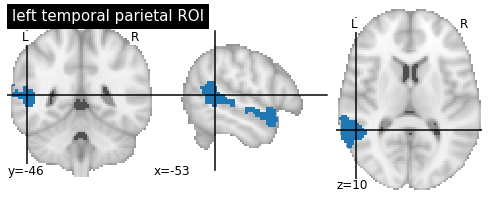

The left "temporal parietal" ROI comprises auditory association
cortex extending from anterior superior temporal cortex to the
temporoparietal junction.


In [4]:
# Visualize the left temporal parietal ROI
roi_img = np.zeros(atlas_img.shape)
for parcel in parcel_labels:
    roi_img[atlas_img == parcel] = 1

# Convert to a NIfTI image for visualization with Nilearn
roi_nii = nib.Nifti1Image(roi_img, atlas_nii.affine, atlas_nii.header)

# Plot plot left temporal parietal ROI
plot_stat_map(roi_nii, cmap='tab10_r', cut_coords=(-53, -46, 10),
              colorbar=False, title='left temporal parietal ROI');
plt.show()

# Print short "figure caption" describing visualization
print('The left "temporal parietal" ROI comprises auditory '
      "association\ncortex extending from anterior superior "
      "temporal cortex to the\ntemporoparietal junction.")

Once data is loaded, we divide the data into two halves for a two fold validation.
We will use one half for training SRM and the other for testing its performance.
Then, we normalize the data each half.

In [5]:
# Get the number of subjects and TRs
n_subjects = len(data)
n_trs = data[0].shape[0]

# Split/compile data into training and test halves
train_data = []
test_data = []
for subject in np.arange(n_subjects):
    
    # Take the first half of TRs as training
    train_data.append(zscore(data[subject][:n_trs//2, :], axis=0).T)
    
    # Take the second half of TRs as testing
    test_data.append(zscore(data[subject][(n_trs//2):, :], axis=0).T)

### Estimating the SRM
Next, we train the SRM on the training data. We need to specify desired dimension of the shared feature space. Although we simply use 50 features, the optimal number of dimensions can be found using grid search with cross-validation. We also need to specify a number of iterations to ensure the SRM algorithm converges.

In [6]:
# Set the number of features of shared space and number of iterations
features = 50
n_iter = 10

# Create an SRM object
srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=features)

# Fit the SRM data
print('Fitting SRM')
srm.fit(train_data)
print('SRM has been fit')
print(f'Share response shape: {srm.s_.shape[0]} '
      f'Features x {srm.s_.shape[1]} Time-points')

Fitting SRM
SRM has been fit
Share response shape: 50 Features x 275 Time-points


After training SRM, we obtain a shared response $S$ that contains the values of the features for each TR, and a set of weight matrices $W_i$ that project from the shared subspace to each subject's idiosyncratic voxel space. Let us check the orthogonal property of the weight matrix $W_i$ for a subject. We visualize $W_i^TW_i$, which should be the identity $I$ matrix with shape equal to the number of features we selected.

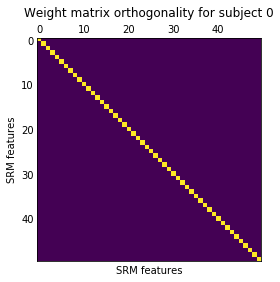

Weight matrix shape: 935 Voxels x 50 Features

This test confirms that the weight matrix for subject 0 is orthogonal.


In [7]:
# Use the first subject as an example
subject = 0

plt.matshow(srm.w_[subject].T.dot(srm.w_[subject]))
plt.title(f'Weight matrix orthogonality for subject {subject}', pad=10)
plt.xlabel('SRM features')
plt.ylabel('SRM features')
plt.tick_params(length=0)
plt.show()

print(f'Weight matrix shape: {srm.w_[subject].shape[0]} '
      f'Voxels x {srm.w_[subject].shape[1]} Features\n')
print("This test confirms that the weight matrix for "
      f"subject {subject} is orthogonal.")

## Between-subject time-segment classification

When we trained SRM above, we learned the weight matrices $W_i$ and the shared response $S$ for the training data. The weight matrices further allow us to convert new data to the shared feature space. We call the `transform()` function to transform test data for each subject into the shred space.

In [8]:
# Transform subject-space test data into shared space
test_shared = srm.transform(test_data)

# z-score the transformed test data
test_shared = [zscore(ts, axis=1) for ts in test_shared]

We evaluate the performance of the SRM using a between-subject time-segment classification analysis with leave-one-subject-out cross-validation (e.g. [Haxby et al., 2011](https://doi.org/10.1016/j.neuron.2011.08.026); [Chen et al., 2015](https://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model). The function receives the data from `N` subjects with a specified window size `win_size` for the time segments. A segment is the concatenation of `win_size` TRs. Then, using the averaged data from `N-1` subjects it tries to match the segments from the left-out subject to the right position. The function returns the average accuracy across segments for each subject.

In [9]:
def time_segment_classification(data, win_size=10): 
    n_subjects = len(data)
    (n_features, n_trs) = data[0].shape
    accuracy = np.zeros(shape=n_subjects)
    n_segments = n_trs - win_size 
    
    # Set up container for training data
    train_data = np.zeros((n_features * win_size, n_segments), order='f')
    
    # Training data (includes test data, but will be removed)
    for m in range(n_subjects):
        for w in range(win_size):
            train_data[w * n_features:(w + 1) * n_features, :] += \
                data[m][:, w:(w + n_segments)]
            
    # Analyze each subject (leave-one-out)
    print("Between-subject time-segment classification accuracy "
          "for each subject:", end=' ')
    for test_subject in range(n_subjects):
        test_data = np.zeros((n_features * win_size, n_segments), order='f')
        for w in range(win_size):
            test_data[w * n_features:(w + 1) * n_features, :] = \
                data[test_subject][:, w:(w + n_segments)]

        A = np.nan_to_num(zscore((train_data - test_data), axis=0))
        B = np.nan_to_num(zscore(test_data, axis=0))

        # Compute correlation matrix
        correlations = compute_correlation(B.T, A.T)

        # Correlation-based classification
        for i in range(n_segments):
            for j in range(n_segments):
                
                # Exclude segments overlapping with the testing segment
                if abs(i - j) < win_size and i != j:
                    correlations[i, j] = -np.inf

        max_idx =  np.argmax(correlations, axis=1)
        accuracy[test_subject] = sum(max_idx == range(n_segments)) / n_segments

        # Print accuracy for each subject as we go
        print(f"{accuracy[test_subject]:.3f}",
              end=', ', flush=True)
        
    print("\nThe average accuracy among all subjects is "
          f"{np.mean(accuracy):.3f} +/- {np.std(accuracy):.3f}")
    return accuracy

Let's compute time segment matching accuracy for the anatomically-aligned data:

In [10]:
# Time-segment classification on anatomically-aligned data
acc_anat_test = time_segment_classification(test_data, win_size=10)

Between-subject time-segment classification accuracy for each subject: 0.102, 0.166, 0.083, 0.000, 0.181, 0.068, 0.053, 0.106, 0.064, 0.072, 0.147, 0.030, 0.143, 0.136, 0.155, 0.128, 0.189, 0.072, 0.106, 0.049, 0.075, 0.162, 0.147, 0.034, 0.185, 0.057, 0.026, 0.128, 0.087, 0.109, 0.143, 0.185, 0.200, 0.140, 0.098, 0.117, 0.117, 0.140, 0.064, 0.140, 0.042, 0.151, 0.151, 0.151, 0.196, 0.117, 
The average accuracy among all subjects is 0.113 +/- 0.050


Now, we compute it after transforming the subjects data with SRM:

In [11]:
# Time-segment classification on SRM data
acc_shared_test = time_segment_classification(test_shared, win_size=10)

Between-subject time-segment classification accuracy for each subject: 0.302, 0.475, 0.272, 0.057, 0.834, 0.155, 0.272, 0.287, 0.377, 0.506, 0.713, 0.049, 0.309, 0.362, 0.808, 0.691, 0.472, 0.136, 0.347, 0.257, 0.487, 0.525, 0.343, 0.091, 0.521, 0.136, 0.094, 0.645, 0.404, 0.385, 0.543, 0.502, 0.725, 0.340, 0.423, 0.366, 0.506, 0.574, 0.468, 0.389, 0.328, 0.275, 0.442, 0.457, 0.521, 0.547, 
The average accuracy among all subjects is 0.407 +/- 0.188


Lastly, we plot the classification accuracies to compare methods. 

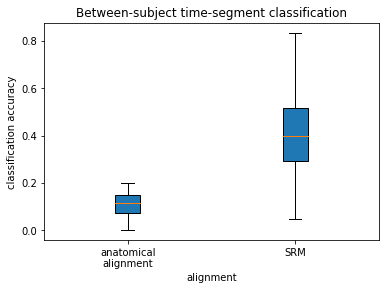

SRM functional alignment provides a marked improvement inbetween-
subject time-segment classification over anatomical alignment.


In [12]:
# Box plot for the classification results
labels = ['anatomical\nalignment', 'SRM']
plt.figure()
plt.boxplot([acc_anat_test, acc_shared_test], vert=True,
            patch_artist=True, labels=labels)
plt.xlabel('alignment')
plt.ylabel('classification accuracy')
plt.title('Between-subject time-segment classification')
plt.show()

print("SRM functional alignment provides a marked improvement in"
      "between-\nsubject time-segment classification over "
      "anatomical alignment.")

## Summary
The SRM allows us to find a reduced-dimension shared response spaces that resolves functional–topographical idiosyncrasies across subjects. We can use the resulting transformation matrices to project test data from any given subject into the shared space. The plot above shows the time segment matching accuracy for the training data, the test data without any transformation, and the test data when SRM is applied. The average performance without SRM is 11%, whereas with SRM is boosted to 40%. Projecting data into the shared space dramatically improves between-subject classification.

#### References
* Chen, P. H. C., Chen, J., Yeshurun, Y., Hasson, U., Haxby, J., & Ramadge, P. J. (2015). A reduced-dimension fMRI shared response model. In C. Cortes, N.D. Lawrence, D.D. Lee, M. Sugiyama, R. Garnett (Eds.), *Advances in Neural Information Processing Systems, vol. 28* (pp. 460-468). https://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model

* Haxby, J. V., Guntupalli, J. S., Connolly, A. C., Halchenko, Y. O., Conroy, B. R., Gobbini, M. I., Hanke, M., & Ramadge, P. J. (2011). A common, high-dimensional model of the representational space in human ventral temporal cortex. *Neuron*, *72*(2), 404-416. https://doi.org/10.1016/j.neuron.2011.08.026

* Haxby, J. V., Guntupalli, J. S., Nastase, S. A., & Feilong, M. (2020). Hyperalignment: Modeling shared information encoded in idiosyncratic cortical topographies. *eLife*, *9*, e56601. https://doi.org/10.7554/eLife.56601

* Nastase, S. A., Liu, Y. F., Hillman, H., Norman, K. A., & Hasson, U. (2020). Leveraging shared connectivity to aggregate heterogeneous datasets into a common response space. *NeuroImage*, *217*, 116865. https://doi.org/10.1016/j.neuroimage.2020.116865

* Anderson, M. J., Capota, M., Turek, J. S., Zhu, X., Willke, T. L., Wang, Y., Chen P.-H., Manning, J. R., Ramadge, P. J., & Norman, K. A. (2016). Enabling factor analysis on thousand-subject neuroimaging datasets.  *2016 IEEE International Conference on Big Data, pages 1151–1160*. http://ieeexplore.ieee.org/document/7840719/
 
* Turek, J. S., Willke, T. L., Chen, P.-H., & Ramadge, P. J. (2017). A semi-supervised method for multi-subject fMRI functional alignment. *2017 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), pages 1098–1102*. https://ieeexplore.ieee.org/document/7952326
 
* Turek, J. S., Ellis, C. T., Skalaban, L. J., Willke, T. L., & Turk-Browne, N. B. (2018). Capturing Shared and Individual Information in fMRI Data, *2018 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP 2018), pages 826-830*. https://ieeexplore.ieee.org/document/8462175

* Richard, H., Martin, L., Pinho, A. L., Pillow, J., & Thirion, B. (2019). Fast shared response model for fMRI data. *arXiv:1909.12537*. https://arxiv.org/abs/1909.12537